In [1]:
import pandas as pd
from scipy import stats
import numpy as np

In [2]:
data = pd.read_csv("abc_test_data - ab_test_data.csv")

In [3]:
data

,DATE,userid,variant,Purchases,Total_purchased_amount
0,2024/05/10,20295,2,21,4
1,2024/04/08,6428,2,6,"0,6"
2,2024/05/08,59675,2,129,"24,4"
3,2024/05/14,30994,2,2757,"526,2"
4,2024/05/14,55427,2,462,"52,6"
...,...,...,...,...,...
79994,2024/04/06,51879,3,588,"23,7"
79995,2024/05/07,6395,1,504,"19,1"
79996,2024/05/11,9887,1,30,"5,7"
79997,2024/05/11,55837,1,1605,"124,5"


### Data Exploration, Cleaning and Outlier Detection and Removal

Looking at all the transactions made by a single user as an example below:

In [4]:
data[data.userid == 34925].sort_values(by='DATE', ascending=True)

,DATE,userid,variant,Purchases,Total_purchased_amount
61852,2024/04/25,34925,2,21,"4,9"
72338,2024/04/27,34925,2,297,"68,4"
79998,2024/04/29,34925,2,120,"27,7"
62848,2024/04/30,34925,2,129,"29,8"
78596,2024/05/04,34925,2,18,"4,1"
25209,2024/05/11,34925,2,57,"6,5"


In [5]:
data.userid.nunique()     # Unique number of users in the data

50397

In [6]:
data = data.sort_values(by='DATE', ascending=True)
data = data.reset_index(drop=True)

I am assuming that the "Total_purchased_amount" column is in the South African format of writing currency values where commas are used instead of a decimal point. For ease of operations I am replacing the commas to decimal points.

In [7]:
data['Total_purchased_amount'] = data['Total_purchased_amount'].str.replace(',', '.')

In [8]:
data

,DATE,userid,variant,Purchases,Total_purchased_amount
0,2024/04/05,26166,3,78,3.7
1,2024/04/05,41697,2,15,0.7
2,2024/04/05,29238,3,702,78.1
3,2024/04/05,6746,1,1083,25
4,2024/04/05,10710,1,30,86.6
...,...,...,...,...,...
79994,2024/05/16,46170,2,2418,455.3
79995,2024/05/16,52468,1,12,2.3
79996,2024/05/16,48191,1,15,3.4
79997,2024/05/17,5187,3,12,1.4


The duration of this ABC test was from April 5th, 2024 to May 17th, 2024

In [9]:
dist = data.groupby("variant")["userid"].nunique()
dist

variant
1    17868
2    17169
3    17244
Name: userid, dtype: int64

In [10]:
percentage = 100*(dist/dist.sum())
percentage

variant
1    34.176852
2    32.839846
3    32.983302
Name: userid, dtype: float64

It is approximately an equal split of user traffic of ~33% between all three variants

First, I would like to see if any users are accidentally randomized into more than one variants.

In [11]:
variant = data.groupby("userid")["variant"].nunique()
dupes = variant[variant > 1]
len(dupes)

1884

In [12]:
data[data.userid == 64737]                 # User 64737 was randomized in variants 1 and 3

,DATE,userid,variant,Purchases,Total_purchased_amount
63084,2024/05/13,64737,3,111,21.2
65095,2024/05/13,64737,1,90,17.2


I would remove these users who have seen more than one variant. This eliminates any kind of bias and only considers the outcome based on pure randomization of the traffic into the test.

In [13]:
userid_to_remove = variant[variant > 1].index
filtered_data = data[~data["userid"].isin(userid_to_remove)]

In [14]:
filtered_data = filtered_data.reset_index(drop=True)
filtered_data

,DATE,userid,variant,Purchases,Total_purchased_amount
0,2024/04/05,26166,3,78,3.7
1,2024/04/05,41697,2,15,0.7
2,2024/04/05,29238,3,702,78.1
3,2024/04/05,6746,1,1083,25
4,2024/04/05,10710,1,30,86.6
...,...,...,...,...,...
74363,2024/05/16,46170,2,2418,455.3
74364,2024/05/16,52468,1,12,2.3
74365,2024/05/16,48191,1,15,3.4
74366,2024/05/17,5187,3,12,1.4


To make sure that the correct number of users are excluded from the original data:

In [15]:
filtered_data.userid.nunique()

48513

In [16]:
data.userid.nunique() - len(dupes)

48513

Secondly, I would like to check if each row in the transactions is unique by date and userid as well. If not, I will sum the purchases and the purchase amounts to make this dataframe's primary keys - date, userid and variant

In [17]:
uni = filtered_data.groupby(["DATE","userid","variant"])["Purchases"].count()
uni[uni > 1]

DATE        userid  variant
2024/04/06  33320   3          2
2024/04/07  17004   3          2
2024/04/20  6421    1          2
2024/04/22  56981   1          2
2024/04/23  44746   3          2
                              ..
2024/05/16  49883   3          2
            52327   2          2
            61708   1          2
            62277   1          2
            64619   3          2
Name: Purchases, Length: 309, dtype: int64

In [18]:
filtered_data['Total_purchased_amount'] = filtered_data['Total_purchased_amount'].astype(float)

In [19]:
new_data = filtered_data.groupby(["DATE","userid","variant"])[["Purchases","Total_purchased_amount"]].sum().reset_index()

In [20]:
new_data

,DATE,userid,variant,Purchases,Total_purchased_amount
0,2024/04/05,69,1,42,4.9
1,2024/04/05,88,3,1377,181.5
2,2024/04/05,98,3,1368,54.3
3,2024/04/05,144,1,1539,36.7
4,2024/04/05,183,2,2253,260.0
...,...,...,...,...,...
74054,2024/05/16,64691,1,168,6.4
74055,2024/05/16,64719,2,51,2.0
74056,2024/05/16,64753,2,1026,38.7
74057,2024/05/17,5187,3,12,1.4


In [21]:
new_data.userid.nunique()    # The users remain the same but now all the rows in the dataframe are unique

48513

In [22]:
check = new_data.groupby(["DATE","userid","variant"])["Purchases"].count()
check[check > 1]

Series([], Name: Purchases, dtype: int64)

Now, I would like to check if there are any outliers that might skew the results in a direction. I will look at both, purchases and the purchased amounts to find outliers.

<AxesSubplot:>

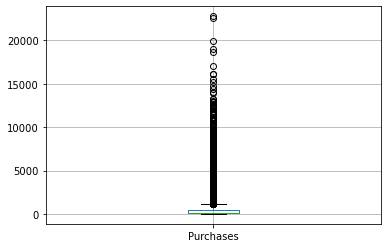

In [23]:
new_data.boxplot(column='Purchases')

<AxesSubplot:>

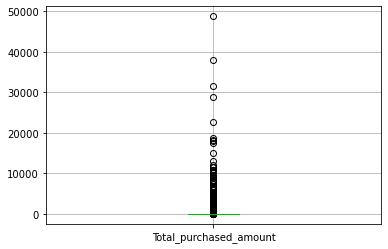

In [24]:
new_data.boxplot(column='Total_purchased_amount')

In [25]:
new_data[(new_data.Purchases >= 15000) | (new_data.Total_purchased_amount >= 20000)].sort_values(by='Total_purchased_amount', ascending=True)

,DATE,userid,variant,Purchases,Total_purchased_amount
50593,2024/05/11,4900,1,15531,586.8
21023,2024/04/28,21739,2,15189,715.0
45134,2024/05/10,4900,1,19887,781.5
5641,2024/04/08,53222,1,22611,912.9
71559,2024/05/16,20270,1,17016,1024.9
71984,2024/05/16,27581,1,16080,1206.2
51894,2024/05/11,21932,3,18975,3584.2
18094,2024/04/23,2334,2,18660,6482.9
18785,2024/04/24,2334,2,22779,7892.8
53118,2024/05/11,39195,2,16125,14980.8


I would like to eliminate these high spending purchases to avoid skewing of the decision.

In [26]:
final_data = new_data[(new_data.Purchases < 15000) & (new_data.Total_purchased_amount < 20000)]
final_data = final_data.reset_index(drop=True)
final_data

,DATE,userid,variant,Purchases,Total_purchased_amount
0,2024/04/05,69,1,42,4.9
1,2024/04/05,88,3,1377,181.5
2,2024/04/05,98,3,1368,54.3
3,2024/04/05,144,1,1539,36.7
4,2024/04/05,183,2,2253,260.0
...,...,...,...,...,...
74039,2024/05/16,64691,1,168,6.4
74040,2024/05/16,64719,2,51,2.0
74041,2024/05/16,64753,2,1026,38.7
74042,2024/05/17,5187,3,12,1.4


Making sure the traffic split in the three variants is still ~33%.

In [27]:
dist2 = final_data.groupby("variant")["userid"].nunique()
dist2

variant
1    16593
2    15931
3    15986
Name: userid, dtype: int64

In [28]:
percentage2 = 100*(dist2/dist2.sum())
percentage2

variant
1    34.205318
2    32.840651
3    32.954030
Name: userid, dtype: float64

In [29]:
final_data.userid.nunique()

48510

### Question 1 : Is there a significant difference in daily revenue generated by each version of the in-app purchase feature?

First, I want to bring the dataframe down to daily revenue level

In [93]:
daily_rev = final_data.groupby(["DATE","variant"])["Total_purchased_amount"].sum().reset_index()
daily_rev

,DATE,variant,Total_purchased_amount
0,2024/04/05,1,51538.3
1,2024/04/05,2,49238.4
2,2024/04/05,3,47466.1
3,2024/04/06,1,79385.5
4,2024/04/06,2,59199.6
...,...,...,...
122,2024/05/15,3,67346.8
123,2024/05/16,1,55120.8
124,2024/05/16,2,60229.2
125,2024/05/16,3,61264.1


In [167]:
summary = daily_rev.groupby('variant')['Total_purchased_amount'].mean()
summary

variant
1    40550.545238
2    37882.271429
3    40281.293023
Name: Total_purchased_amount, dtype: float64

In [95]:
rev_1 = daily_rev[daily_rev['variant'] == 1]['Total_purchased_amount']
rev_2 = daily_rev[daily_rev['variant'] == 2]['Total_purchased_amount']
rev_3 = daily_rev[daily_rev['variant'] == 3]['Total_purchased_amount']

I am using the t-test hypothesis testing method since I am working with continuous data and comparing means between groups.

In [96]:
# 1 vs 2
t_stat_12, p_value_12 = stats.ttest_ind(rev_1, rev_2)
# 1 vs 3
t_stat_13, p_value_13 = stats.ttest_ind(rev_1, rev_3)
# 2 vs 3
t_stat_23, p_value_23 = stats.ttest_ind(rev_2, rev_3)

In [100]:
# Bonferroni correction
alpha = 0.05
adjusted_alpha = alpha / 3 
adjusted_alpha

0.016666666666666666

Bonferroni correction adjusts the significance level to account for multiple comparisons, reducing the risk of false positives.

In [101]:
sig_12 = p_value_12 < adjusted_alpha
print(sig_12)
p_value_12

False


0.711594417850025

In [102]:
sig_13 = p_value_13 < adjusted_alpha
print(sig_13)
p_value_13

False


0.970866766760517

In [103]:
sig_23 = p_value_23 < adjusted_alpha
print(sig_23)
p_value_23

False


0.7444249085869532

There does not seem to be any statistical difference between the different versions regarding daily revenue brought in by the feature. But based on the mean alone, variant 1 should be rolled out with respect to the KPI daily revenue.

### Question 2: How does user purchasing behavior differ across the three feature variants?

##### 1. Is there a difference in single purchase values 

##### 2. Is there a difference in number of purchases

Here, I am assuming that the "single purchase values" means the "average value / amount for every purchase" called Average Order Value (AOV). I am calculating it as: total_purchased_amount / purchases

In [104]:
users = final_data.groupby(["userid","variant"])[["Purchases","Total_purchased_amount"]].sum().reset_index()
users

,userid,variant,Purchases,Total_purchased_amount
0,1,2,1317,92.2
1,2,3,72,3.6
2,3,1,54,3.9
3,4,3,309,69.6
4,5,1,213,23.2
...,...,...,...,...
48505,64758,3,42,6.0
48506,64759,2,30,0.7
48507,64760,1,258,9.6
48508,64761,1,843,18.4


In [105]:
users["AOV"] = users["Total_purchased_amount"] / users["Purchases"]

In [106]:
users

,userid,variant,Purchases,Total_purchased_amount,AOV
0,1,2,1317,92.2,0.070008
1,2,3,72,3.6,0.050000
2,3,1,54,3.9,0.072222
3,4,3,309,69.6,0.225243
4,5,1,213,23.2,0.108920
...,...,...,...,...,...
48505,64758,3,42,6.0,0.142857
48506,64759,2,30,0.7,0.023333
48507,64760,1,258,9.6,0.037209
48508,64761,1,843,18.4,0.021827


In [107]:
aov_1 = users[users['variant'] == 1]['AOV']
aov_2 = users[users['variant'] == 2]['AOV']
aov_3 = users[users['variant'] == 3]['AOV']

In [108]:
# 1 vs 2
t_stat_aov_12, p_value_aov_12 = stats.ttest_ind(aov_1, aov_2)
# 1 vs 3
t_stat_aov_13, p_value_aov_13 = stats.ttest_ind(aov_1, aov_3)
# 2 vs 3
t_stat_aov_23, p_value_aov_23 = stats.ttest_ind(aov_2, aov_3)

In [109]:
# Bonferroni correction
alpha = 0.05
adjusted_alpha = alpha / 3

In [110]:
sig_aov_12 = p_value_aov_12 < adjusted_alpha
print(sig_aov_12)
p_value_aov_12

False


0.36126643808818504

In [111]:
sig_aov_13 = p_value_aov_13 < adjusted_alpha
print(sig_aov_13)
p_value_aov_13

False


0.5331241424801791

In [112]:
sig_aov_23 = p_value_aov_23 < adjusted_alpha
print(sig_aov_23)
p_value_aov_23

False


0.20620524746730753

In [165]:
users.groupby('variant')['AOV'].mean()

variant
1    0.140731
2    0.154802
3    0.136069
Name: AOV, dtype: float64

There does not seem to be any statistical difference between the user behavior in terms of single purchase values. Based on the mean AOV, variant 2 should be rolled out.

In [113]:
pur_1 = users[users['variant'] == 1]['Purchases']
pur_2 = users[users['variant'] == 2]['Purchases']
pur_3 = users[users['variant'] == 3]['Purchases']

In [114]:
# 1 vs 2
t_stat_pur_12, p_value_pur_12 = stats.ttest_ind(pur_1, pur_2)
# 1 vs 3
t_stat_pur_13, p_value_pur_13 = stats.ttest_ind(pur_1, pur_3)
# 2 vs 3
t_stat_pur_23, p_value_pur_23 = stats.ttest_ind(pur_2, pur_3)

In [115]:
sig_pur_12 = p_value_pur_12 < adjusted_alpha
print(sig_pur_12)
p_value_pur_12

True


0.005246952616834418

In [116]:
sig_pur_13 = p_value_pur_13 < adjusted_alpha
print(sig_pur_13)
p_value_pur_13

False


0.2801776470612611

In [117]:
sig_pur_23 = p_value_pur_23 < adjusted_alpha
print(sig_pur_23)
p_value_pur_23

True


6.92982250659887e-05

In [118]:
purchase_summary = users.groupby('variant')['Purchases'].mean()
purchase_summary

variant
1    709.235400
2    654.704287
3    730.533780
Name: Purchases, dtype: float64

From the t-test and the above summary, it can be seen that the variants 1 and 3 significantly exceed variant 2 in terms of number of purchases. There is no significant difference between variants 1 and 3 in terms of number of purchases. Although, variant 3 received more purchases than variant 1, there does not seem to be a statistically significant difference. So based on number of purchases alone, variant 3 should be rolled out.

### Question 3: Does any feature variant lead to better user retention?

In [30]:
final_data['DATE'] = pd.to_datetime(final_data['DATE'])

I am doing cohort analysis to calculate the daily retention rates by variant.

In [31]:
data_final_cohort = final_data.sort_values(by=['userid', 'DATE'])

In [32]:
data_final_cohort['cohort_date'] = data_final_cohort.groupby('userid')['DATE'].transform('min')

In [34]:
data_final_cohort['days_since_cohort'] = (data_final_cohort['DATE'] - data_final_cohort['cohort_date']).dt.days

In [35]:
data_final_cohort

,DATE,userid,variant,Purchases,Total_purchased_amount,cohort_date,days_since_cohort
24278,2024-05-07,1,2,408,30.7,2024-05-07,0
44720,2024-05-10,1,2,207,7.9,2024-05-07,3
58854,2024-05-13,1,2,273,20.8,2024-05-07,6
62848,2024-05-14,1,2,429,32.8,2024-05-07,7
21743,2024-04-30,2,3,72,3.6,2024-04-30,0
...,...,...,...,...,...,...,...
4742,2024-04-07,64760,1,156,7.1,2024-04-06,1
7010,2024-04-09,64760,1,24,0.6,2024-04-06,3
50214,2024-05-10,64761,1,735,16.8,2024-05-10,0
62847,2024-05-13,64761,1,108,1.6,2024-05-10,3


In [37]:
variant_data = data_final_cohort.groupby(['variant', 'cohort_date', 'days_since_cohort'])['userid'].nunique().reset_index()
variant_data

,variant,cohort_date,days_since_cohort,userid
0,1,2024-04-05,0,452
1,1,2024-04-05,1,87
2,1,2024-04-05,2,70
3,1,2024-04-05,3,42
4,1,2024-04-05,4,56
...,...,...,...,...
2258,3,2024-05-14,1,50
2259,3,2024-05-14,2,32
2260,3,2024-05-15,0,704
2261,3,2024-05-15,1,54


In [38]:
variant_cohort_sizes = variant_data[variant_data['days_since_cohort'] == 0][['variant', 'cohort_date', 'userid']]
variant_cohort_sizes = variant_cohort_sizes.rename(columns={'userid': 'cohort_size'})

In [39]:
variant_cohort_sizes

,variant,cohort_date,cohort_size
0,1,2024-04-05,452
42,1,2024-04-06,532
83,1,2024-04-07,349
123,1,2024-04-08,245
162,1,2024-04-09,225
...,...,...,...
2248,3,2024-05-12,808
2253,3,2024-05-13,832
2257,3,2024-05-14,796
2260,3,2024-05-15,704


In [143]:
variant_data = pd.merge(variant_data, variant_cohort_sizes, on=['variant', 'cohort_date'])

In [145]:
variant_data['retention_rate'] = variant_data['userid'] / variant_data['cohort_size']
variant_data

,variant,cohort_date,days_since_cohort,userid,cohort_size,retention_rate
0,1,2024-04-05,0,452,452,1.000000
1,1,2024-04-05,1,87,452,0.192478
2,1,2024-04-05,2,70,452,0.154867
3,1,2024-04-05,3,42,452,0.092920
4,1,2024-04-05,4,56,452,0.123894
...,...,...,...,...,...,...
2258,3,2024-05-14,1,50,796,0.062814
2259,3,2024-05-14,2,32,796,0.040201
2260,3,2024-05-15,0,704,704,1.000000
2261,3,2024-05-15,1,54,704,0.076705


In [152]:
retention_rates = {
    'var_1': variant_data[variant_data['variant'] == 1]['retention_rate'].values,
    'var_2': variant_data[variant_data['variant'] == 2]['retention_rate'].values,
    'var_3': variant_data[variant_data['variant'] == 3]['retention_rate'].values,
}

In [153]:
# 1 vs 2
t_stat_rr_12, p_value_rr_12 = stats.ttest_ind(retention_rates['var_1'], retention_rates['var_2'], equal_var=False)
# 1 vs 3
t_stat_rr_13, p_value_rr_13 = stats.ttest_ind(retention_rates['var_1'], retention_rates['var_3'], equal_var=False)
# 2 vs 3
t_stat_rr_23, p_value_rr_23 = stats.ttest_ind(retention_rates['var_2'], retention_rates['var_3'], equal_var=False)

In [154]:
sig_rr_12 = p_value_rr_12 < adjusted_alpha
print(sig_rr_12)
p_value_rr_12

False


0.8701016797080405

In [155]:
sig_rr_13 = p_value_rr_13 < adjusted_alpha
print(sig_rr_13)
p_value_rr_13

False


0.8777954806604905

In [156]:
sig_rr_23 = p_value_rr_23 < adjusted_alpha
print(sig_rr_23)
p_value_rr_23

False


0.7489040861181299

In [166]:
variant_data.groupby('variant')['retention_rate'].mean()

variant
1    0.092206
2    0.090341
3    0.093985
Name: retention_rate, dtype: float64

There does not seem to be any statistical difference between the retention rates across the three variants. Based on retention rate alone, the variant 3 seems to win over the other two variations.

### Conclusion

Based on the data provided and the question statements, all 3 variants have advantages and disadvantages. Variant 1 performed better than the other two variants in terms of the metric "Daily Revenue". Variant 2 peformed better in terms of AOV. Variant 3 had the best number of purchases and retention rates. Both variants 1 & 3 performed well overall except in terms of single purchase value (AOV).